# Interpreting Tree Models

You'll need to install the `treeinterpreter` library. 

In [2]:
# !pip install treeinterpreter

In [8]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

from treeinterpreter import treeinterpreter as ti

from IPython.display import Image

In [9]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.1.


## For Regression task

Load the dataset.

In [10]:
cal_housing = fetch_california_housing()

In [11]:
print(cal_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [12]:
X = cal_housing.data
y = cal_housing.target
cal_features = cal_housing.feature_names

df = pd.concat((pd.DataFrame(X, columns=cal_features),
                pd.DataFrame({'MedianHouseVal': y})), axis=1)

In [13]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### Visualizing a Decision Tree

You will need to install the `pydotplus` library.

In [18]:
#!pip install pydotplus

In [14]:
import pydotplus

In [16]:
# Create dataset
X_train, X_test, y_train, y_test = train_test_split(df[cal_features], y, test_size=0.2)

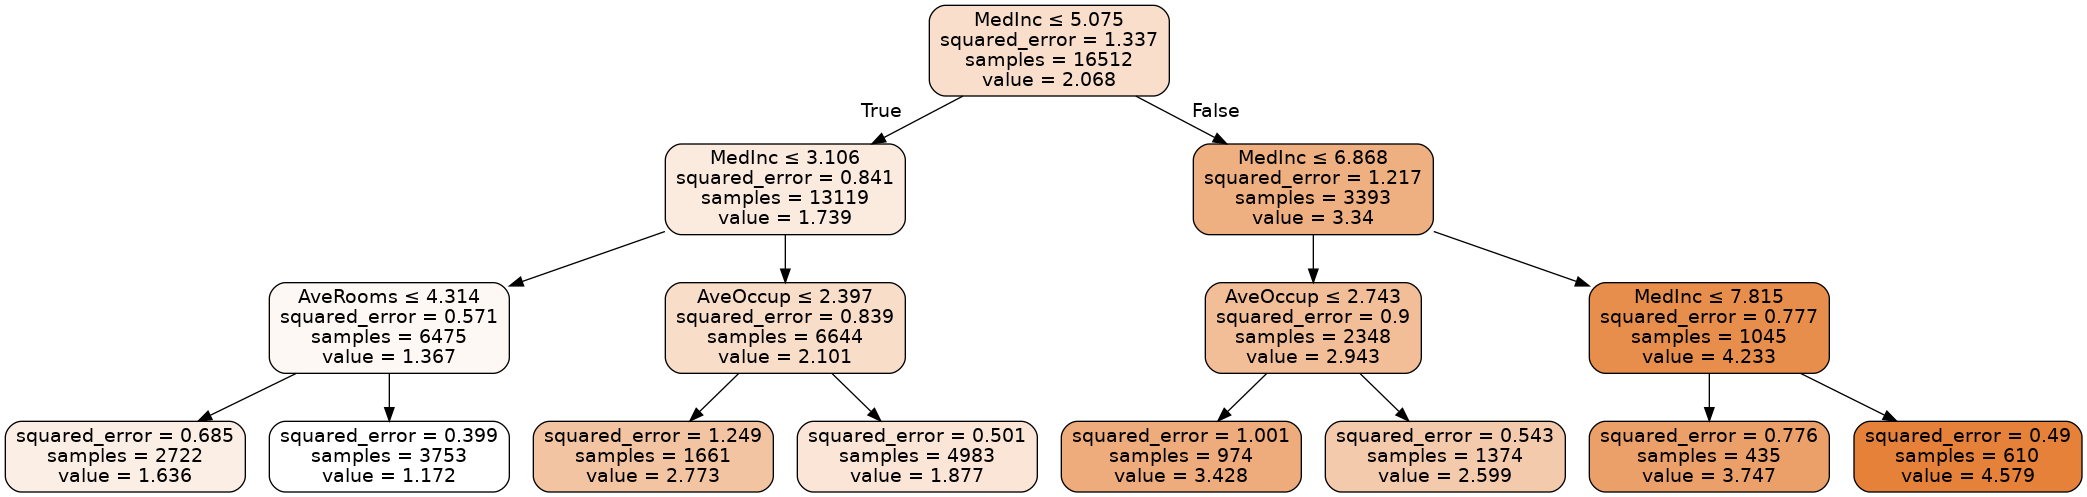

In [18]:
dt_reg = DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X_train, y_train)

dot_data = export_graphviz(dt_reg, out_file="ca_housing.dot",
                           feature_names=cal_features,
                           filled=True, rounded=True,
                           special_characters=True,
                           leaves_parallel=False)
graph = pydotplus.graphviz.graph_from_dot_file("ca_housing.dot")
Image(graph.create_png())

Make a sample prediction.

In [19]:
X_test[cal_features].iloc[[0]].transpose()

,16986
MedInc,5.957200
HouseAge,17.000000
AveRooms,5.670384
AveBedrms,1.008674
Population,1941.000000
AveOccup,2.405204
Latitude,37.550000
Longitude,-122.260000


In [20]:
dt_reg.predict(X_test[cal_features].iloc[[0]])

array([3.42777028])

The root node is the mean of the labels from the training data.

In [21]:
y_train.mean()

2.0678738299418606

#### Train a simple Random Forest

In [22]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
print(f'Instance 11 prediction: {rf_reg.predict(X_test.iloc[[11]])}')
print(f'Instance 17 prediction: {rf_reg.predict(X_test.iloc[[17]])}')

Instance 11 prediction: [1.6272303]
Instance 17 prediction: [4.8203671]


In [31]:
idx = 11
from treeinterpreter import treeinterpreter
prediction, bias, contributions = treeinterpreter.predict(rf_reg,
                                             X_test.iloc[[idx]].values)
print(f'prediction: {prediction}')
print(f'bias: {bias}')
print(f'contributions: {contributions}')

prediction: [[1.6272303]]
bias: [2.06854048]
contributions: [[-0.95730866 -0.01659199 -0.10754417  0.12281316  0.60712801 -0.05952097
   0.02122049 -0.05150605]]


In [26]:
for idx in [11, 17]:
    print(f'Instance: {idx}')
    prediction, bias, contributions = treeinterpreter.predict(
        rf_reg, X_test.iloc[[idx]].values)
    print(f'Bias term (training set mean): {bias}')
    print(f'Feature contributions:')
    for contribution, feature in sorted(zip(contributions[0],
                                            cal_features),
                                        key=lambda x: -abs(x[0])):
        print(feature, round(contribution, 2))
    print('-'*20) 

Instance: 11
Bias term (training set mean): [2.06854048]
Feature contributions:
MedInc -0.96
Population 0.61
AveBedrms 0.12
AveRooms -0.11
AveOccup -0.06
Longitude -0.05
Latitude 0.02
HouseAge -0.02
--------------------
Instance: 17
Bias term (training set mean): [2.06854048]
Feature contributions:
MedInc 2.8
HouseAge -0.18
Population 0.07
AveBedrms 0.04
Longitude -0.02
AveRooms 0.02
Latitude 0.01
AveOccup 0.0
--------------------


In [32]:
idx = 17
prediction, bias, contributions = treeinterpreter.predict(
    rf_reg, X_test.iloc[[idx]].values)
print(f'prediction: {prediction[0]}')
print(f'bias + contributions: {bias + np.sum(contributions)}')

prediction: [4.8203671]
bias + contributions: [4.8203671]


In fact, we can check that this holds for all elements of the test set:

In [33]:
predictions, biases, contributions = treeinterpreter.predict(
    rf_reg, X_test.values)

assert(np.allclose(np.squeeze(predictions), biases + np.sum(contributions, axis=1)))
assert(np.allclose(rf_reg.predict(X_test), biases + np.sum(contributions, axis=1)))

## Comparing Contributions across data slices

In [34]:
X1_test = X_test[:X_test.shape[0]//2:]
X2_test = X_test[X_test.shape[0]//2:]

In [ ]:
predictions1, biases1, contributions1 = ti.predict(rf_reg, X1_test.values)
predictions2, biases2, contributions2 = ti.predict(rf_reg, X2_test.values)

In [ ]:
total_contribs1 = np.mean(contributions1, axis=0) 
total_contribs2 = np.mean(contributions2, axis=0) 

print(f'Total contributions from X1_test: {total_contribs1}')
print(f'Total contributions from X2_test: {total_contribs2}')

print(f'Sum of feature contributions differences: {np.sum(total_contribs1 - total_contribs2)}')
print(f'Difference between the average predictions: {np.mean(predictions1) - np.mean(predictions2)}')

## TreeExplainer with SHAP

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [22]:
import xgboost as xgb
xgb_reg = xgb.XGBClassifier(max_depth=3,
                            n_estimators=300,
                            learning_rate=0.05)
xgb_reg.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:15:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [25]:
model_mse_error = np.sqrt(np.mean((xgb_reg.predict(X_test) - y_test)**2))
print(f'Mean squared error of MLP model: {model_mse_error}')

Mean squared error of MLP model: 6.05303719295192


In [30]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value[1],
                shap_values[1][0,:],
                X_train.iloc[0,:])

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_train.iloc[:1000,:])

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License